### Introduction
The bioactivity dataset is extracted from [ExcapeDB](https://solr.ideaconsult.net/search/excape/) chemogenomics database. Here, the main task is to build quatitative structure-activity relationship model(QSAR) to predict the molecule.

### Import required libraries

In [1]:
"""
Created on Tuesday 17 May 2022
Author: ZAW
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from torch.utils.data import TensorDataset

In [2]:
data = pd.read_csv("SLC6A4_active_excape_export.csv")
data.head()

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,AZMKBJHIXZCVNL-BXKDBHETNA-N,44590643,6532,A,5.68382,pubchem,393260,9606,SLC6A4,4061,FC1=CC([C@@H]2O[C@H](CC2)CN)=C(OC)C=C1
1,AZMKBJHIXZCVNL-UHFFFAOYNA-N,11492305,6532,A,5.16210,pubchem,393258,9606,SLC6A4,4061,FC1=CC(C2OC(CC2)CN)=C(OC)C=C1
2,AZOHUEDNMOIDOC-GETDIYNLNA-N,44419340,6532,A,6.66354,pubchem,276059,9606,SLC6A4,4061,FC1=CC=C(C[C@H]2C[C@@H](N(CC2)CC=C)CCCNC(=O)NC...
3,AZSKJKSQZWHDOK-VJSLDGLSNA-N,CHEMBL1080745,6532,A,6.96000,chembl20,617082,9606,SLC6A4,4061,C=1C=C(C=CC1)C2=CC(=C(N2CC(C)C)C)C(NCCCN3CCN(C...
4,AZTPZTRJVCAAMX-UHFFFAOYNA-N,CHEMBL578346,6532,A,8.00000,chembl20,596934,9606,SLC6A4,4061,C1=CC=C2C(=C1)C=C(C(N(C3CCNCC3)C4CCC4)=O)C=C2


We are interested in SMILES(encoded chemical structure), pxC50(log10 converted IC50 or EC50). 
The pXC50 is the −log10 of the molarity concentration of the compound.

We will use RDKit(Cheminformtics Software) to convert SMILES into molecular fingerprint.

,SMILES,Molecule
0,FC1=CC([C@@H]2O[C@H](CC2)CN)=C(OC)C=C1,
1,FC1=CC(C2OC(CC2)CN)=C(OC)C=C1,
2,FC1=CC=C(C[C@H]2C[C@@H](N(CC2)CC=C)CCCNC(=O)NC...,
3,C=1C=C(C=CC1)C2=CC(=C(N2CC(C)C)C)C(NCCCN3CCN(C...,
4,C1=CC=C2C(=C1)C=C(C(N(C3CCNCC3)C4CCC4)=O)C=C2,

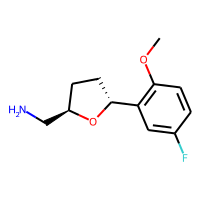
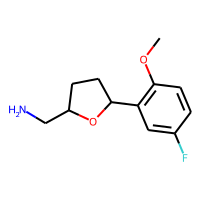
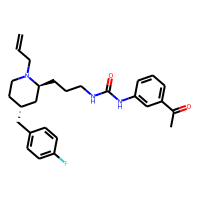
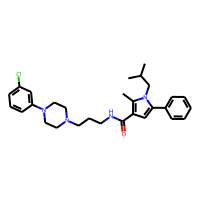
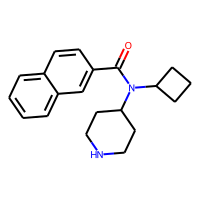

In [3]:
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
PandasTools.AddMoleculeColumnToFrame(data, 'SMILES','Molecule') # pandastools is use to create molecule column
data[['SMILES','Molecule']].head()

We can see that all the SMILES are converted into molecule structure.


### Check NaN in molecules
We need the molecule is fully converted from SMILES or not. Becuase the ExcapeDB use different toolit(Ambit).

In [4]:
data.Molecule.isna().sum()

0

All the SMILES are converted.

### Vectorizing the molecules

The next step is to vecotorize the molecules. Becuase the molecule can not be directly feed to ml model. We will vectorize the molecule by calculating the Morgan fingerprint. In this way, all the molecules will be vectorized into numbers which can be used for modeling.

In [5]:
#molecule to fingerprint function
def mol2fp(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,3)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp,ar)
    return ar

In [6]:
data['FPs'] = data.Molecule.apply(mol2fp)

### Split Dataset

In [7]:
X = np.stack(data.FPs.values)
print(X.shape)

(7228, 2048)


In [8]:
y = data.pXC50.values.reshape((-1,1))
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.10,random_state=3)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.05, random_state=3)

In [9]:
#Normalize the output
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [10]:
#remove low vaiance features
feature_select = VarianceThreshold(threshold=0.05)
X_train = feature_select.fit_transform(X_train)
X_validation = feature_select.transform(X_validation)
X_test = feature_select.transform(X_test)
X_train.shape

(6179, 223)

### Convert the dataset to pytorch tensor

In [11]:
# transfer arrays to GPU memory as tensors
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [12]:
X_train = torch.tensor(X_train,device=device).float()
X_test  = torch.tensor(X_test,device=device).float()
X_validation = torch.tensor(X_validation,device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()
y_validation = torch.tensor(y_validation,device=device).float()
X_train

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [13]:
X_train.shape

torch.Size([6179, 223])

### Create Tensor dataset
Pytorch work with datasets and dataloaders to feed the minibatches to the model during training, so we convert the data. It’s easy to create a dataset from the already created tensors. The batch size is set to 256 and the trainloader will shuffle the data when an epoch has been used.

In [14]:
train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 256, shuffle = True)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = 256, shuffle = True)

### Build Model

In [15]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net,self).__init__()

        # Three layers and a output layer
        self.fc1 = nn.Linear(input_size, hidden_size) # first full-connected layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size) # Output layer

        #Layer normalizatin for faster training
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)
        
        #LeadkyReLU will be used as activation function
        self.activation = nn.LeakyReLU()

        #Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x): # Forward pass: stacking each layer together
        # Fully conected
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out - self.dropout(out)
        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)

        #Final output layer
        out = self.fc_out(out)

        return out


In [16]:
# Defining the hyperparameters
input_size = X_train.size()[-1]
hidden_size = 1024
dropout_rate = 0.80
output_size = 1
learning_rate = 0.001
model = Net(input_size, hidden_size, dropout_rate,output_size)

The model can be moved to the GPU with the.cuda() method inherited from the nn.Module class.

In [17]:
model.cuda()

Net(
  (fc1): Linear(in_features=223, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_out): Linear(in_features=1024, out_features=1, bias=True)
  (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.8, inplace=False)
)

For a loss function I'll use the mean squared error. Adam is chosen for the optimizer.

In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Training is a bit more handheld than in Keras. This gives flexibility to train the network layers in different ways, but here we just train it with all the data. For each epoch, the running_loss is zeroed, and the minibatches fetched from the train data in the DatLoader. We start each mini-bach loop by zeroing the gradients. All forward computations done from this point on, will be recorded and used to calculate the backward pas needed for optimizing the weights of the network. At the end of each epoch, some statistics is printed so that it'st possible to follwo the training.


In [19]:
model.train() #Ensure the network is in "train" mode with dropouts active
epochs = 200
for e in range(epochs):
    running_loss = 0
    for fps, labels in train_loader:
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pa
         
        output = model(fps) #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass
        optimizer.step() # Optimize the weights
         
        running_loss += loss.item()
    else:
        if e%10 == 0:
            validation_loss = torch.mean(( y_validation - model(X_validation) )**2).item()
            print("Epoch: %3i Training loss: %0.2F Validation loss: %0.2F"%(e,(running_loss/len(train_loader)), validation_loss))

Epoch:   0 Training loss: 1.77 Validation loss: 0.99
Epoch:  10 Training loss: 0.46 Validation loss: 0.44
Epoch:  20 Training loss: 0.34 Validation loss: 0.39
Epoch:  30 Training loss: 0.30 Validation loss: 0.41
Epoch:  40 Training loss: 0.26 Validation loss: 0.38
Epoch:  50 Training loss: 0.24 Validation loss: 0.41
Epoch:  60 Training loss: 0.22 Validation loss: 0.40
Epoch:  70 Training loss: 0.21 Validation loss: 0.36
Epoch:  80 Training loss: 0.20 Validation loss: 0.39
Epoch:  90 Training loss: 0.20 Validation loss: 0.42
Epoch: 100 Training loss: 0.20 Validation loss: 0.42
Epoch: 110 Training loss: 0.19 Validation loss: 0.44
Epoch: 120 Training loss: 0.18 Validation loss: 0.40
Epoch: 130 Training loss: 0.18 Validation loss: 0.40
Epoch: 140 Training loss: 0.17 Validation loss: 0.41
Epoch: 150 Training loss: 0.16 Validation loss: 0.41
Epoch: 160 Training loss: 0.17 Validation loss: 0.42
Epoch: 170 Training loss: 0.15 Validation loss: 0.44
Epoch: 180 Training loss: 0.16 Validation loss

Before using the model for predticion, it must be set to evaluation mode, where the dropout layers are no longer active. We can calcuate the predction on the training set, validation set ant external test set.

In [20]:
model.eval()# Switch to evaluation mode, where dropout is switched off
y_pred_train = model(X_train)
y_pred_validation = model(X_validation)
y_pred_test = model(X_test)

Calculating the root mean square error can be done using the pytorch operators. The .item() method converts single element tensors to pYthon Scalars for printing.

In [21]:
torch.mean((y_train - y_pred_train)**2).item()

0.09443994611501694

In [22]:
torch.mean((y_validation - y_pred_validation)**2).item()

0.40165975689888

In [23]:
torch.mean((y_test - y_pred_test)**2).item()

0.36628347635269165

The error on the held out test set is actually lower than the validation set, although both are much worse than the train set. Thisw indicates overfitting, even though the dropout rate was set high at 0.8. Finally, lets evaluate the model visually. Before that is possible there seem to be a need to transport the tensor to cpu, detach it from gradient before we can convert it to numpy and flatten it.

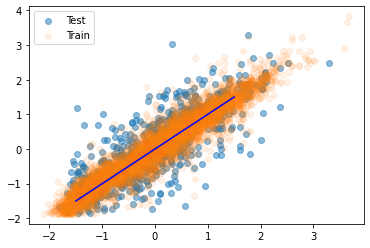

In [24]:
def flatten(tensor):
    return tensor.cpu().detach().numpy().flatten()
plt.scatter(flatten(y_pred_test), flatten(y_test), alpha=0.5, label='Test')
plt.scatter(flatten(y_pred_train), flatten(y_train),alpha=0.1, label='Train')
plt.legend()
plt.plot([-1.5, 1.5],[-1.5,1.5], c="b")

If we want to predict an arbitary molecule, we have to remember to use the VaraicneThrshold object on the fingerprints and also reverse scale the prediction from the feed forward neural network. 
The scikit_lean objects are already fit and can be used here.

In [25]:
def predict_smiles(smiles):
    fp = mol2fp(Chem.MolFromSmiles(smiles)).reshape(1,-1)
    fp_filtered = feature_select.transform(fp)
    fp_tensor = torch.tensor(fp_filtered, device = device).float()
    prediction = model(fp_tensor)

    #return prediction.cpu().detach().numpy()
    pXC50 = scaler.inverse_transform(prediction.cpu().detach().numpy())
    return pXC50[0][0]
predict_smiles('Cc1ccc2c(N3CCNCC3)cc(F)cc2n1')

7.090232